Copied from step 5. But here we are focued on a representative dataset.

In [1]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
from scipy.stats import ttest_ind

sys.path.insert(0, '../..')
from mining import * 
from isf_helper import (extract_ms2_spectrum, 
                        get_comprehensive_stats_per_dataset, 
                        explain_a_dataset_by_mz_deltas, 
                        explain_a_dataset_byMS2)


In [2]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_45studies_orbi.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [3]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'ACN*2'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''14.0155	900	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
18.0104	885	18.010565	water	{'H': 2, 'O': 1}
2.0155	717	2.01565	± 2H, opening or forming of double bond	{'H': 2}
44.0261	652	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
28.0312	621	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
15.9948	479	15.9949	oxidation	{'O': 1}
17.0264	451	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
26.0155	440	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
27.9947	433	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
42.0104	340	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
67.9872	325	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
13.9791	321	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
23.9998	317	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
16.0312	314	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
42.0468	314	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
46.0053	313	46.005305	formic acid adduct	{'C': 1, 'H': 2, 'O': 2}
88.0522	304	88.052429	butanoic acid	{'C': 4, 'H': 8, 'O': 2}
30.0468	267	30.04695	addition of C2H4 and hydrogenation. Reaction: (+C2H4) and (+H2)	{'C': 2, 'H': 6}
35.037	157	35.037114	addition of water and addition of ammonia. Reaction: (+H2O) and (+NH3)	{'H': 5, 'N': 1, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [4]:
ion_mode = 'pos'
cur_study = 'ST001237_HILICpos_B2_ppm5_3524314'
_n, list_features = read_features_from_asari_table(
    open(f'../../../input_data_orbi/{cur_study}/full_feature_table.tsv').read()
)

for f in list_features:
    f['representative_intensity'] = f['peak_area']
list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                        list_features, 
                        isotope_search_patterns=isotope_search_patterns_pos, 
                        adduct_search_patterns=adduct_search_patterns_pos,
                        extended_adducts=extended_adducts, 
                        mz_tolerance_ppm=5,
                        rt_tolerance=dict_rtwindow[cur_study],
                        mode=ion_mode,
                        charges=[1, 2, 3],
                        )

# convert khipu instances to dicts
list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                    key=lambda x: x['neutral_formula_mass'], reverse=True)
fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]

# by isf_candidate_fragments
explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
    list_khipus, remaining_features, pos_isf_candidate_fragments, 
    rt_stdev=dict_rtwindow[cur_study]
    )

for f in list_features:
    f['peak_area'] = float(f['peak_area'])
intensities = np.array([f['peak_area'] for f in list_features])
x1 = np.quantile(intensities, 0.9)

M0_H_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['ion_relation'] == 'M0,M+H+' and f['peak_area'] > x1]
fragment_ids = explained_feature_ids
singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids and f['peak_area'] > x1]

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '1120a_Marios_PD1_Inhib2_HP-PREFA58', '1040_Marios_PD1_Inhib2_HP-EA717425-8', '1040a_Marios_PD1_Inhib2_HP-PREFA54', '1040b_Marios_PD1_Inhib2_HP-PREFB54', '1041_Marios_PD1_Inhib2_HP-E9133655-7', '1042_Marios_PD1_Inhib2_HP-L1376088-6', '1043_Marios_PD1_Inhib2_HP-L1305560-7', '1044_Marios_PD1_Inhib2_HP-L1370589-6', '1045_Marios_PD1_Inhib2_HP-E9123619-6']
Read 57875 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M+H+       Na/H      CH3OH        K/H        ACN     NaCOOH
M0         1.007276  22.989216  33.033491  38.963158  42.033825  68.994700
13C/12C    2.010631  23.992571  34.036846  39.966513  43.037180  69.998055
37Cl/35Cl  3.004276  24.986216  35.030491  40.960158  44.030825  70.991700
13C/12C*2  3.013986  24.995926  35.040201  40.969868  44.04053

In [6]:
import pandas as pd

cur_df = pd.read_csv(f'../../../input_data_orbi/{cur_study}/full_feature_table.tsv', sep='\t')

In [9]:
def fetch_stats_for_ttest(df, list_ids):
    '''
    return intensities, cselectivity, snr, detection_counts, goodness_fitting
    '''
    
    return df[df['id_number'].isin(list_ids)]['peak_area'], \
        df[df['id_number'].isin(list_ids)]['cSelectivity'], \
            df[df['id_number'].isin(list_ids)]['snr'], df[df['id_number'].isin(list_ids)]['detection_counts'], df[df['id_number'].isin(list_ids)]['goodness_fitting']
                

In [10]:
M0_H_stats = fetch_stats_for_ttest(cur_df, M0_H_ids)
singletons_stats = fetch_stats_for_ttest(cur_df, singleton_ids)

In [11]:
for stat in zip(M0_H_stats, singletons_stats):
    t_stat, p_value = ttest_ind(stat[0], stat[1])
    print(p_value)

1.2445103543201915e-25
7.018316419315056e-23
0.2600101375873114
0.08729236389647263
4.9191709642989135e-12


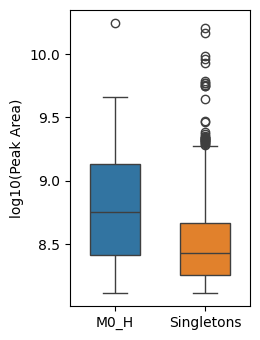

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 3.5))
boxplot = sns.boxplot(data={'M0_H': np.log10(M0_H_stats[0]), 'Singletons': np.log10(singletons_stats[0])}, width=0.55)
# for i, patch in enumerate(boxplot.patches):
#     hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
#     patch.set_hatch(hatch)
#     patch.set_edgecolor('black')  # Set border color
#     patch.set_facecolor('white')  # Remove fill color

# ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Peak Area)")
# ax.set_title("M0+H+ vs singleton -- peak area")
plt.tight_layout()
plt.savefig('peak_area.pdf')

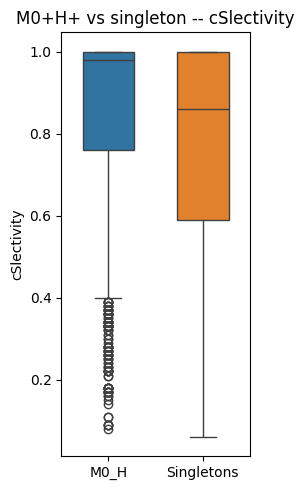

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 5))
boxplot = sns.boxplot(data={'M0_H': M0_H_stats[1], 'Singletons': singletons_stats[1]}, width=0.55)
# for i, patch in enumerate(boxplot.patches):
#     hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
#     patch.set_hatch(hatch)
#     patch.set_edgecolor('black')  # Set border color
#     patch.set_facecolor('white')  # Remove fill color

# ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("cSlectivity")
ax.set_title("M0+H+ vs singleton -- cSlectivity")
plt.tight_layout()
plt.savefig('cselectivity.pdf')

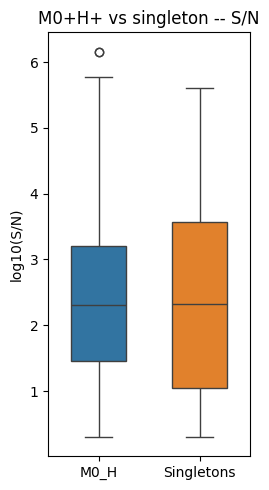

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 5))
boxplot = sns.boxplot(data={'M0_H': np.log10(M0_H_stats[2]), 'Singletons': np.log10(singletons_stats[2])}, width=0.55)
# for i, patch in enumerate(boxplot.patches):
#     hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
#     patch.set_hatch(hatch)
#     patch.set_edgecolor('black')  # Set border color
#     patch.set_facecolor('white')  # Remove fill color

# ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(S/N)")
ax.set_title("M0+H+ vs singleton -- S/N")
plt.tight_layout()
plt.savefig('signal_noise_ratio.pdf')

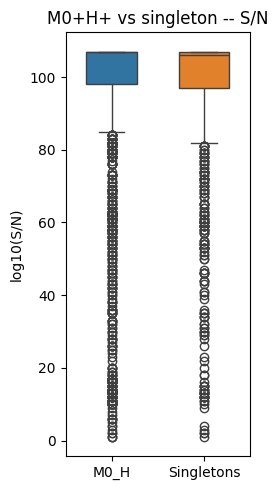

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 5))
boxplot = sns.boxplot(data={'M0_H': M0_H_stats[3], 'Singletons': singletons_stats[3]}, width=0.55)
# for i, patch in enumerate(boxplot.patches):
#     hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
#     patch.set_hatch(hatch)
#     patch.set_edgecolor('black')  # Set border color
#     patch.set_facecolor('white')  # Remove fill color

# ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Dectection counts")
ax.set_title("M0+H+ vs singleton -- detection counts")
plt.tight_layout()
plt.savefig('signal_noise_ratio.pdf')

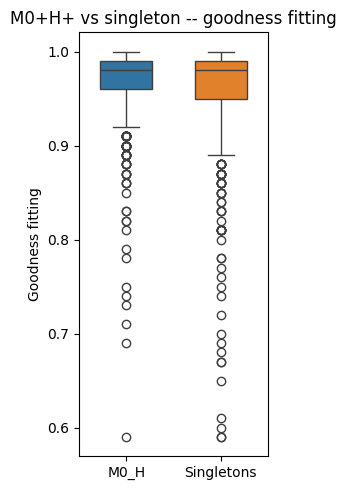

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 5))
boxplot = sns.boxplot(data={'M0_H': M0_H_stats[4], 'Singletons': singletons_stats[4]}, width=0.55)
# for i, patch in enumerate(boxplot.patches):
#     hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
#     patch.set_hatch(hatch)
#     patch.set_edgecolor('black')  # Set border color
#     patch.set_facecolor('white')  # Remove fill color

# ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Goodness fitting")
ax.set_title("M0+H+ vs singleton -- goodness fitting")
plt.tight_layout()
plt.savefig('goodness_fitting.pdf')